# **Introduction:**

**Research Question**

This paper endeavors to answer the following question: "How might we create a personalized music recommendation system for users based on their listening history, without being invasive or relying on personal data?"




**Background / Relevance for Study**

 In today's digital age, music streaming services such as Spotify are becoming increasingly popular. However, users often struggle to find new music that suits their tastes with such a vast selection of music. Personalized music recommendation systems have become a popular solution to this problem. Given users' listening history, these systems can suggest new music that they may enjoy. Unfortunately, many existing systems rely heavily on users' personal data (eg: age, location, etc.), which raises concerns about privacy. Our proposed model aims to create a personalized music recommendation system that relies on users' listening history without being invasive. Presently, Spotify recommends content based both on the actual content of songs that a user likes, and also the relationship that one track has with other tracks, determined by a broader set of users. 

Our proposed response to our main query is to to create a 
novel music recommendation algorithm that differs from that of Spotify. Spotify present incorporates multiple recommendation methods, chiefly:


1.   Content-Based Recommendation
2.   Collaborative-Based Recommendation
3.Popularity-based recommendation

It is our objective to create a new method which does not incorporate collaborative-based recommendation. The goal of this change is to enhance the privacy of users such that their listening history is not communicated with other users, directly or indirectly.

As an example illustrating this use case, if a user (Bob) has one friend on spotify (Rob), Bob might be aware that Rob is an avid fan of Norwegian death metal if he receives that as a recommendation. Rob may prefer to keep that private, and would feasibly choose to opt into our algorithm which eschews collaborate-based recommendation in favor of his privacy.


**Varaibles, Parameters, and Assumptions**

Our variables will include users' listening history, the genres and artists of the music they listen to, and their interactions with the music streaming service (such as liking, disliking, or skipping songs). We will assume that users' listening history reflects their music preferences to some extent. We will also assume that the music streaming service has access to a large enough database of music to make relevant recommendations.


**Limitations of Data**

We source our data from KaggleSet data (https://www.kaggle.com/datasets/mrmorj/dataset-of-songs-in-spotify). While KaggleSet provides a large quantity of data, it does not contain every single song on Spotify; thus, not every song on a user's playlist may be represented in the data, renderinig the recommendation algorithm less accurate given its reduced information. In particular, our data source only holds information on: **[Trap, Techno, Techhouse, Trance, Psytrance, Dark Trap, DnB (drums and bass), Hardstyle, Underground Rap, Trap Metal, Emo, Rap, RnB, Pop, Hiphop].** 

Each song has a set of accomanying labels with further data, such as danceability, energy, loudness, musical key, and level of instrumentality (to name a few).

Our project and technical analysis consists of 5 major components, enumerated below:

1. Data Collection and Cleaning: 



## Imports

In [1]:
import pandas as pd
import numpy as np
import json
import re 
import sys
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

In [3]:
#Makes using jupyter notebook on laptops much easier
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Data Processing
dataset link: https://www.kaggle.com/datasets/ektanegi/spotifydata-19212020

In [4]:
# data is at a song level
spotify_df = pd.read_csv('data.csv')
spotify_df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


In [5]:
# data is at an artist level
data_w_genre = pd.read_csv('data_w_genres.csv')
data_w_genre.head()

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres
0,"""Cats"" 1981 Original London Cast",0.575083,0.442750,247260.000000,0.386336,0.022717,0.287708,-14.205417,0.180675,115.983500,0.334433,38.000000,5,1,12,['show tunes']
1,"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,33.076923,5,1,26,[]
2,"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.285714,0,1,7,[]
3,"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.444444,0,1,27,[]
4,"""Joseph And The Amazing Technicolor Dreamcoat""...",0.605444,0.437333,232428.111111,0.429333,0.037534,0.216111,-11.447222,0.086000,120.329667,0.458667,42.555556,11,1,9,[]


In [6]:
# checking for genres
data_w_genre.dtypes

artists              object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
mode                  int64
count                 int64
genres               object
dtype: object

In [7]:
# genre value actually a string that looks like a list
data_w_genre['genres'].values[0]

"['show tunes']"

In [8]:
# regex statement to extract the genre and input into a list
data_w_genre['genres_upd'] = data_w_genre['genres'].apply(lambda x: [re.sub(' ','_',i) for i in re.findall(r"'([^']*)'", x)])
data_w_genre['genres_upd'].values[0][0]

'show_tunes'

In [9]:
# extract artists into a list
spotify_df['artists_upd_v1'] = spotify_df['artists'].apply(lambda x: re.findall(r"'([^']*)'", x))
spotify_df['artists'].values[0]

"['Carl Woitschach']"

In [10]:
spotify_df['artists_upd_v1'].values[0][0]

'Carl Woitschach'

In [11]:
# double check for empty llsts: didn't work for artists with an apostrophe in their title enclosed in full quotes
spotify_df[spotify_df['artists_upd_v1'].apply(lambda x: not x)].head(5)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,artists_upd_v1
127,0.995,"[""Sam Manning's and His Cole Jazz Orchestra""]",0.664,173333,0.283,0,42WDMm9hX0xCFkkKpt6NOY,0.87400,8,0.109,-18.301,0,Bungo,0,1930-01-01,0.0807,99.506,0.688,1930,[]
180,0.984,"[""Scarlet D'Carpio""]",0.400,142443,0.190,0,4Gcc2YB0AAlzPLQhosdyAw,0.90000,0,0.182,-12.062,1,Chililin Uth'aja,0,1930,0.0492,81.290,0.402,1930,[]
1244,0.506,"[""Original Broadway Cast Of 'Flahooley""]",0.519,35227,0.475,0,1Qt9zpHUfVqMNr25EU9IFL,0.07100,7,0.103,-9.553,0,Prologue,0,1951-01-01,0.1070,105.639,0.615,1951,[]
1478,0.809,"[""Cal Tjader's Modern Mambo Quintet""]",0.795,238200,0.386,0,5VeW5QJDW906P5knRgJWzt,0.87400,1,0.106,-14.984,1,Dearly Beloved,2,1954-09-11,0.0570,119.800,0.807,1954,[]
1944,0.804,"[""Screamin' Jay Hawkins""]",0.574,142893,0.401,0,6MC85zBk1dQqnywRDdzy7h,0.00002,2,0.546,-11.185,1,I Love Paris,14,1958,0.0533,89.848,0.587,1958,[]


In [12]:
# catch the special case above and combine 2
spotify_df['artists_upd_v2'] = spotify_df['artists'].apply(lambda x: re.findall('\"(.*?)\"',x))
spotify_df['artists_upd'] = np.where(spotify_df['artists_upd_v1'].apply(lambda x: not x), spotify_df['artists_upd_v2'], spotify_df['artists_upd_v1'] )

In [13]:
spotify_df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,...,name,popularity,release_date,speechiness,tempo,valence,year,artists_upd_v1,artists_upd_v2,artists_upd
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,...,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928,[Carl Woitschach],[],[Carl Woitschach]
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,...,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928,"[Robert Schumann, Vladimir Horowitz]",[],"[Robert Schumann, Vladimir Horowitz]"
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,...,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928,[Seweryn Goszczyński],[],[Seweryn Goszczyński]
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,...,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928,[Francisco Canaro],[],[Francisco Canaro]
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,...,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928,"[Frédéric Chopin, Vladimir Horowitz]",[],"[Frédéric Chopin, Vladimir Horowitz]"


In [14]:
# create own song identifier (duplicates of same song with different ids)
spotify_df['artists_song'] = spotify_df.apply(lambda row: row['artists_upd'][0] + row['name'], axis = 1)
spotify_df.sort_values(['artists_song','release_date'], ascending = False, inplace = True)

In [15]:
spotify_df[spotify_df['name']=='Adore You']

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,...,popularity,release_date,speechiness,tempo,valence,year,artists_upd_v1,artists_upd_v2,artists_upd,artists_song
97046,0.1110,['Miley Cyrus'],0.583,278747,0.655,0,5AnCLGg35ziFOloEnXK4uu,0.000004,0,0.113,...,70,2013-10-04,0.0315,119.759,0.201,2013,[Miley Cyrus],[],[Miley Cyrus],Miley CyrusAdore You
87868,0.0237,['Harry Styles'],0.676,207133,0.771,0,3jjujdWJ72nww5eGnfs2E7,0.000007,8,0.102,...,88,2019-12-13,0.0483,99.048,0.569,2019,[Harry Styles],[],[Harry Styles],Harry StylesAdore You
87883,0.0237,['Harry Styles'],0.676,207133,0.771,0,1M4qEo4HE3PRaCOM7EXNJq,0.000007,8,0.102,...,86,2019-12-06,0.0483,99.048,0.569,2019,[Harry Styles],[],[Harry Styles],Harry StylesAdore You


In [16]:
spotify_df.drop_duplicates('artists_song',inplace = True)
spotify_df[spotify_df['name']=='Adore You']

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,...,popularity,release_date,speechiness,tempo,valence,year,artists_upd_v1,artists_upd_v2,artists_upd,artists_song
97046,0.1110,['Miley Cyrus'],0.583,278747,0.655,0,5AnCLGg35ziFOloEnXK4uu,0.000004,0,0.113,...,70,2013-10-04,0.0315,119.759,0.201,2013,[Miley Cyrus],[],[Miley Cyrus],Miley CyrusAdore You
87868,0.0237,['Harry Styles'],0.676,207133,0.771,0,3jjujdWJ72nww5eGnfs2E7,0.000007,8,0.102,...,88,2019-12-13,0.0483,99.048,0.569,2019,[Harry Styles],[],[Harry Styles],Harry StylesAdore You


1. Explode artists column in the previous so each artist within a song will have their own row
2. Merge data_w_genre to the exploded dataset in Step 1 so that the previous dataset no is enriched with genre dataset

In [17]:
# explode: Transform each element of a list-like to a row, replicating index values.
artists_exploded = spotify_df[['artists_upd','id']].explode('artists_upd')
artists_exploded.head()

,artists_upd,id
60450,黑豹,3KIuCzckjdeeVuswPo20mC
72795,黃蜀娟,7dkMnOK1h9I3D2NyDDjBfh
72861,黃蜀娟,7ilXPF7IilGtVX4MMubQfQ
72826,黃蜀娟,3enJcaHwRwN3ABPp3Bae35
72790,黃蜀娟,6aewX7cGeXnZTK36bZRI6T


In [18]:
# merging two datasets( left: artists_exploded, right: data_w_genre)
artists_exploded_enriched = artists_exploded.merge(data_w_genre, how = 'left', left_on = 'artists_upd',right_on = 'artists')
artists_exploded_enriched_nonnull = artists_exploded_enriched[~artists_exploded_enriched.genres_upd.isnull()]
artists_exploded_enriched_nonnull[artists_exploded_enriched_nonnull['id'] =='6KuQTIu1KoTTkLXKrwlLPV']

,artists_upd,id,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres,genres_upd
51108,Robert Schumann,6KuQTIu1KoTTkLXKrwlLPV,Robert Schumann,0.98417,0.362023,212320.169960,0.105301,0.782029,0.160324,-22.831075,0.048055,98.447067,0.277442,3.723320,5.0,1.0,253.0,"['classical', 'early romantic era']","[classical, early_romantic_era]"
51109,Vladimir Horowitz,6KuQTIu1KoTTkLXKrwlLPV,Vladimir Horowitz,0.99007,0.343210,266541.125104,0.118844,0.879508,0.183812,-23.193418,0.043360,94.900679,0.225951,3.592378,1.0,1.0,1207.0,"['classical', 'classical performance', 'classi...","[classical, classical_performance, classical_p..."


In [19]:
# group by the song id and consolidate genres list
artists_genres_consolidated = artists_exploded_enriched_nonnull.groupby('id')['genres_upd'].apply(list).reset_index()
artists_genres_consolidated['consolidated_genre_lists'] = artists_genres_consolidated['genres_upd'].apply(lambda x: list(set(list(itertools.chain.from_iterable(x)))))
artists_genres_consolidated.head()

,id,genres_upd,consolidated_genre_lists
0,000G1xMMuwxNHmwVsBdtj1,"[[candy_pop, dance_rock, new_romantic, new_wav...","[new_wave, candy_pop, new_wave_pop, dance_rock..."
1,000ZxLGm7jDlWCHtcXSeBe,"[[boogie-woogie, piano_blues, ragtime, stride]]","[boogie-woogie, ragtime, stride, piano_blues]"
2,000jBcNljWTnyjB4YO7ojf,[[]],[]
3,000mGrJNc2GAgQdMESdgEc,"[[classical, late_romantic_era], [historic_orc...","[orchestral_performance, historic_orchestral_p..."
4,000u1dTg7y1XCDXi80hbBX,"[[country, country_road, country_rock]]","[country_road, country, country_rock]"


In [20]:
spotify_df = spotify_df.merge(artists_genres_consolidated[['id','consolidated_genre_lists']], on = 'id',how = 'left')
spotify_df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,...,release_date,speechiness,tempo,valence,year,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidated_genre_lists
0,0.381,['黑豹'],0.353,316160,0.6860,0,3KIuCzckjdeeVuswPo20mC,0.000000,11,0.0568,...,1992-12-22,0.0395,200.341,0.3520,1992,[黑豹],[],[黑豹],黑豹DON'T BREAK MY HEART,"[chinese_indie_rock, chinese_indie]"
1,0.978,['黃蜀娟'],0.153,156813,0.0581,0,7dkMnOK1h9I3D2NyDDjBfh,0.000939,10,0.1550,...,1968-02-28,0.0472,174.060,0.0904,1968,[黃蜀娟],[],[黃蜀娟],黃蜀娟輕煙濃霧,[]
2,0.828,['黃蜀娟'],0.508,100133,0.2470,0,7ilXPF7IilGtVX4MMubQfQ,0.000000,3,0.2970,...,1968-02-28,0.1730,170.629,0.6800,1968,[黃蜀娟],[],[黃蜀娟],黃蜀娟踏雪尋梅,[]
3,0.909,['黃蜀娟'],0.140,284040,0.1310,0,3enJcaHwRwN3ABPp3Bae35,0.000042,10,0.6190,...,1968-01-28,0.0455,82.543,0.1160,1968,[黃蜀娟],[],[黃蜀娟],黃蜀娟藍色的月光,[]
4,0.944,['黃蜀娟'],0.604,173627,0.2100,0,6aewX7cGeXnZTK36bZRI6T,0.000007,0,0.2110,...,1968-01-28,0.0395,105.531,0.5380,1968,[黃蜀娟],[],[黃蜀娟],黃蜀娟薔薇之戀,[]


# Feature Engineering

In [21]:
# we only need the year of the song released the remaining date information are irrelevant
spotify_df['year'] = spotify_df['release_date'].apply(lambda x: x.split('-')[0])
spotify_df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,...,release_date,speechiness,tempo,valence,year,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidated_genre_lists
0,0.381,['黑豹'],0.353,316160,0.6860,0,3KIuCzckjdeeVuswPo20mC,0.000000,11,0.0568,...,1992-12-22,0.0395,200.341,0.3520,1992,[黑豹],[],[黑豹],黑豹DON'T BREAK MY HEART,"[chinese_indie_rock, chinese_indie]"
1,0.978,['黃蜀娟'],0.153,156813,0.0581,0,7dkMnOK1h9I3D2NyDDjBfh,0.000939,10,0.1550,...,1968-02-28,0.0472,174.060,0.0904,1968,[黃蜀娟],[],[黃蜀娟],黃蜀娟輕煙濃霧,[]
2,0.828,['黃蜀娟'],0.508,100133,0.2470,0,7ilXPF7IilGtVX4MMubQfQ,0.000000,3,0.2970,...,1968-02-28,0.1730,170.629,0.6800,1968,[黃蜀娟],[],[黃蜀娟],黃蜀娟踏雪尋梅,[]
3,0.909,['黃蜀娟'],0.140,284040,0.1310,0,3enJcaHwRwN3ABPp3Bae35,0.000042,10,0.6190,...,1968-01-28,0.0455,82.543,0.1160,1968,[黃蜀娟],[],[黃蜀娟],黃蜀娟藍色的月光,[]
4,0.944,['黃蜀娟'],0.604,173627,0.2100,0,6aewX7cGeXnZTK36bZRI6T,0.000007,0,0.2110,...,1968-01-28,0.0395,105.531,0.5380,1968,[黃蜀娟],[],[黃蜀娟],黃蜀娟薔薇之戀,[]


In [22]:
# one hot encoding for popularity (consider not sure if I wanna do this)
ohe_cols = 'popularity'
spotify_df['popularity'].describe()

count    155469.000000
mean         31.306987
std          21.422973
min           0.000000
25%          12.000000
50%          33.000000
75%          48.000000
max          97.000000
Name: popularity, dtype: float64

In [23]:
# create 5 point buckets for popularity
spotify_df['popularity_red'] = spotify_df['popularity'].apply(lambda x: int(x/5))

In [24]:
# extract columns with float data types
float_cols = spotify_df.dtypes[spotify_df.dtypes == 'float64'].index.values
print(float_cols)

['acousticness' 'danceability' 'energy' 'instrumentalness' 'liveness'
 'loudness' 'speechiness' 'tempo' 'valence']


# TF-IDF 
1st linear algebra: implemented with matrices   
provide weight to song genre based on how often they appear
- generic types (eg: pop): don't want to influence model that significantly
- unique / specific type (eg: abstract classical): want to influence model more

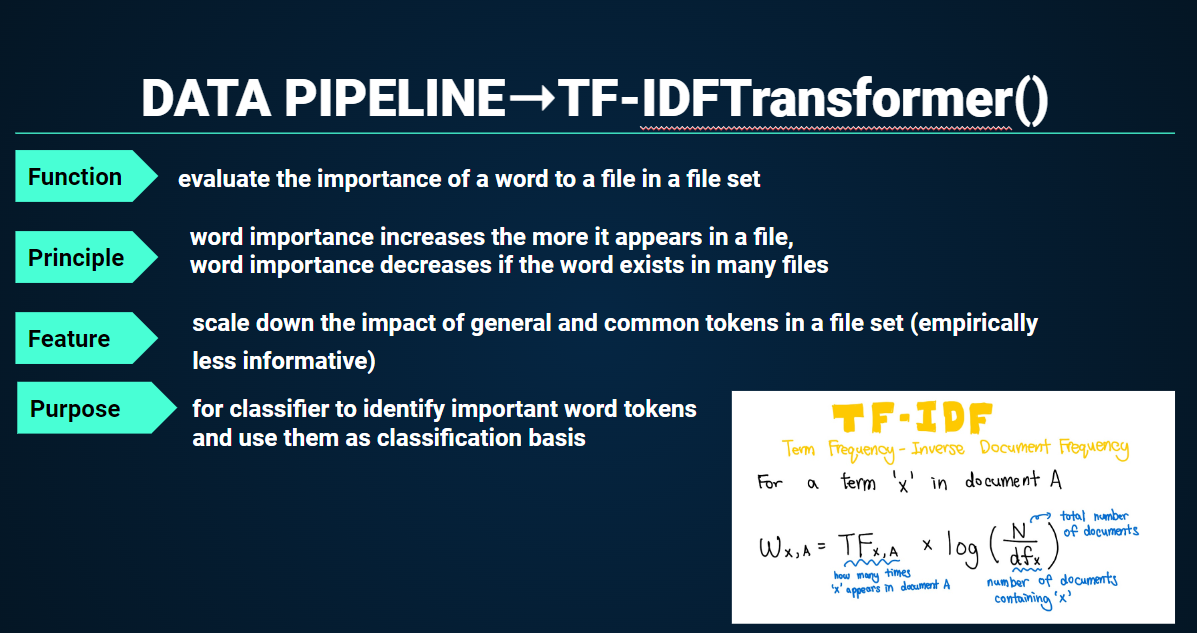

In [25]:
# tf-idf slide from my previous research implementation for better understanding
from IPython.display import Image
Image("./tf-idf.png")

In [26]:
#simple function to create OHE features (helper function)
def ohe_prep(df, column, new_name): 
    """ 
    Create One Hot Encoded features of a specific column

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        column (str): Column to be processed
        new_name (str): new column name to be used
        
    Returns: 
        tf_df: One hot encoded features 
    """
    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df

In [27]:
# tfidf can't handle nulls so fill any null values with an empty list
spotify_df['consolidated_genre_lists'] = spotify_df['consolidated_genre_lists'].apply(lambda d: d if isinstance(d, list) else [])

In [28]:
#function to build entire feature set
def create_feature_set(df, float_cols):
    """ 
    Process spotify df to create a final set of features that will be used to generate recommendations

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        float_cols (list(str)): List of float columns that will be scaled 
        
    Returns: 
        final: final set of features 
    """
    
    #tfidf genre lists
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['consolidated_genre_lists'].apply(lambda x: " ".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names_out()]
    genre_df.reset_index(drop = True, inplace=True)

    #explicity_ohe = ohe_prep(df, 'explicit','exp')    
    year_ohe = ohe_prep(df, 'year','year') * 0.5
    popularity_ohe = ohe_prep(df, 'popularity_red','pop') * 0.15

    #scale float columns
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

    #concanenate all features
    final = pd.concat([genre_df, floats_scaled, popularity_ohe, year_ohe], axis = 1)
     
    #add song id
    final['id']=df['id'].values
    
    return final

In [29]:
complete_feature_set = create_feature_set(spotify_df, float_cols=float_cols)#.mean(axis = 0)
complete_feature_set.head()

,genre|432hz,genre|_hip_hop,genre|a_cappella,genre|abstract,genre|abstract_beats,genre|abstract_hip_hop,genre|accordeon,genre|accordion,genre|acid_house,genre|acid_jazz,...,year|2012,year|2013,year|2014,year|2015,year|2016,year|2017,year|2018,year|2019,year|2020,id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3KIuCzckjdeeVuswPo20mC
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7dkMnOK1h9I3D2NyDDjBfh
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7ilXPF7IilGtVX4MMubQfQ
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3enJcaHwRwN3ABPp3Bae35
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6aewX7cGeXnZTK36bZRI6T


## Connect to Spotify API

In [30]:
# client id and secret
import os
#hiding credentials imports
from dotenv import load_dotenv
load_dotenv()   # take environment variables from dotenv
client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")

redirecturi='http://www.google.com/'
thescope='playlist-read-private'

In [31]:
scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

In [32]:
# need to copy and past the url redirected to / opens new chrome window page
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)
token = util.prompt_for_user_token(scope, client_id= client_id, client_secret=client_secret, redirect_uri='http://localhost')

In [33]:
sp = spotipy.Spotify(auth=token)

In [36]:
#gather playlist names and images. 
#images aren't going to be used until I start building a UI
id_name = {}
list_photo = {}
for i in sp.current_user_playlists()['items']:

    id_name[i['name']] = i['uri'].split(':')[2]
    list_photo[i['uri'].split(':')[2]] = i['images'][0]['url']


{'Pop Mixes': '0YffkQMd5a3sBHTbLhd7M4', 'Mandopop': '6kJj7QwiyYyZtGKjcsxrjw', '1990s': '1t8ExOIdw7kEWfqNrBebPG', '2010s': '0LrfRDSVIgZlP8dHhcHDNb', '懷舊歌': '0EINRTosiLtUqPzBvk00G6', 'kpop': '3YjfERBuWBMXKvGj3ErK0K'}


In [37]:
# pull all playlists from profile
id_name

{'Pop Mixes': '0YffkQMd5a3sBHTbLhd7M4',
 'Mandopop': '6kJj7QwiyYyZtGKjcsxrjw',
 '1990s': '1t8ExOIdw7kEWfqNrBebPG',
 '2010s': '0LrfRDSVIgZlP8dHhcHDNb',
 '懷舊歌': '0EINRTosiLtUqPzBvk00G6',
 'kpop': '3YjfERBuWBMXKvGj3ErK0K'}

In [38]:
def create_necessary_outputs(playlist_name,id_dic, df):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        playlist_name (str): name of the playlist you'd like to pull from the spotify API
        id_dic (dic): dictionary that maps playlist_name to playlist_id
        df (pandas dataframe): spotify datafram
        
    Returns: 
        playlist: all songs in the playlist THAT ARE AVAILABLE IN THE KAGGLE DATASET
    """
    
    #generate playlist dataframe
    playlist = pd.DataFrame()
    playlist_name = playlist_name

    for ix, i in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):
        #print(i['track']['artists'][0]['name'])
        playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[ix, 'name'] = i['track']['name']
        playlist.loc[ix, 'id'] = i['track']['id'] # ['uri'].split(':')[2]
        playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']
        playlist.loc[ix, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    playlist = playlist[playlist['id'].isin(df['id'].values)].sort_values('date_added',ascending = False)
    
    return playlist

In [46]:
from skimage import io
import matplotlib.pyplot as plt

def visualize_songs(df):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    
    temp = df['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))))
    columns = 5
    
    for i, url in enumerate(temp):
        plt.subplot(int(len(temp) / columns + 1), columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['name'].values[i], fontsize = 12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

In [43]:
playlist_pop = create_necessary_outputs('Pop Mixes', id_name,spotify_df)

In [44]:
playlist_pop

,artist,name,id,url,date_added
99,LMFAO,Shots,1V4jC0vJ5525lEF1bFgPX2,https://i.scdn.co/image/ab67616d00001e026a0f2b...,2023-04-23 19:40:27+00:00
1,Shakira,Waka Waka (This Time for Africa) [The Official...,2Cd9iWfcOpGDHLz6tVA3G4,https://i.scdn.co/image/ab67616d00001e02752d2b...,2023-04-23 19:32:20+00:00
45,Kiana Ledé,Wicked Games,0TYhf0MgEj4YJaKwo5c4Km,https://i.scdn.co/image/ab67616d00001e026a8933...,2023-04-23 19:32:20+00:00
47,James Arthur,Say You Won't Let Go,5uCax9HTNlzGybIStD3vDh,https://i.scdn.co/image/ab67616d00001e0220beb6...,2023-04-23 19:32:20+00:00
48,Anne-Marie,2002,2BgEsaKNfHUdlh97KmvFyo,https://i.scdn.co/image/ab67616d00001e0238aae7...,2023-04-23 19:32:20+00:00
49,R. City,Locked Away (feat. Adam Levine),7x5xYW5W42OGPAdHUyyguy,https://i.scdn.co/image/ab67616d00001e029519b1...,2023-04-23 19:32:20+00:00
50,Marshmello,FRIENDS,08bNPGLD8AhKpnnERrAc6G,https://i.scdn.co/image/ab67616d00001e02569f64...,2023-04-23 19:32:20+00:00
51,Jonas Blue,Perfect Strangers,3P3pw6C19j31Rnzgo3JG7o,https://i.scdn.co/image/ab67616d00001e025b6bcc...,2023-04-23 19:32:20+00:00
55,Zedd,Stay,6uBhi9gBXWjanegOb2Phh0,https://i.scdn.co/image/ab67616d00001e02b993cb...,2023-04-23 19:32:20+00:00
57,Bishop Briggs,River,3mRLHiSHYtC8Hk7bzZdUs1,https://i.scdn.co/image/ab67616d00001e028cae50...,2023-04-23 19:32:20+00:00


In [ ]:
visualize_songs(playlist_pop)